### Loading used packages

In [8]:
import os 
import subprocess
import imageio
from glob import glob
import numpy as np
from osgeo import gdal, ogr
import geopandas as gpd
from matplotlib import pyplot as plt

### Define some functions for finding images download and calculating mean, writing out images

In [2]:
image_files_dir = r'Monthly/'
output_file = r'mean_no2_moldova.tif'
moldova_shape = r'moldova.shp'

In [3]:
# a. find the files
def find_files(directory):
    # using glob to get all tif files downloaded in Monthly folder 
    images_path = sorted(glob(directory + r'*.tif'))
    return images_path

In [4]:
images_path = find_files(image_files_dir)
print(images_path)

['Monthly\\Monthly_NO2_Moldova_2023_01.tif', 'Monthly\\Monthly_NO2_Moldova_2023_02.tif', 'Monthly\\Monthly_NO2_Moldova_2023_03.tif', 'Monthly\\Monthly_NO2_Moldova_2023_04.tif', 'Monthly\\Monthly_NO2_Moldova_2023_05.tif', 'Monthly\\Monthly_NO2_Moldova_2023_06.tif', 'Monthly\\Monthly_NO2_Moldova_2023_07.tif', 'Monthly\\Monthly_NO2_Moldova_2023_08.tif', 'Monthly\\Monthly_NO2_Moldova_2023_09.tif', 'Monthly\\Monthly_NO2_Moldova_2023_10.tif', 'Monthly\\Monthly_NO2_Moldova_2023_11.tif', 'Monthly\\Monthly_NO2_Moldova_2023_12.tif']


In [5]:
# b. calculate the mean values of 12 months and write out the image for resample and clip later
def calculate_mean_and_write_out(images_path, output_file):
    image_array_list = []
    for image_path in images_path:
        dataset = gdal.Open(image_path)
        image_array_list.append(dataset.ReadAsArray())
    mean_image_array = np.mean(np.array(image_array_list), axis=0)
    
    (y_size, x_size) = mean_image_array.shape
    print(f'mean image shape: {(y_size, x_size)}')
    driver = gdal.GetDriverByName('GTiff')
    output_image = driver.Create(output_file, x_size, y_size, 1, gdal.GDT_Float32)
    
    output_image.SetGeoTransform(dataset.GetGeoTransform())
    output_image.SetProjection(dataset.GetProjection())
    
    output_image.GetRasterBand(1).WriteArray(mean_image_array)
    output_image.GetRasterBand(1).SetNoDataValue(-9999)
    output_image.FlushCache()

In [6]:
calculate_mean_and_write_out(images_path=images_path, output_file=output_file)

mean image shape: (337, 273)


### Using gdal command for resample and clip 

In [7]:
subprocess.run(r'gdal_translate -of GTiff -tr 2000 2000 mean_no2_moldova.tif mean_no2_moldova_2000.tif')

CompletedProcess(args='gdal_translate -of GTiff -tr 2000 2000 mean_no2_moldova.tif mean_no2_moldova_2000.tif', returncode=0)

In [42]:
subprocess.run(r'gdalwarp -cutline moldova.shp -crop_to_cutline mean_no2_moldova_2000.tif mean_no2_moldova_2000_clip.tif')

CompletedProcess(args='gdalwarp -cutline moldova.shp -crop_to_cutline -srcnodata -9999 mean_no2_moldova_2000.tif mean_no2_moldova_2000_clip5.tif', returncode=0)

### 3. loading the resulting file in jupyter using packages

In [6]:
# image path 
image_file_path = r'mean_no2_moldova_2000_clip.tif'

In [9]:
# read the images using gdal and show it using matplotlib
dataset = gdal.Open(image_file_path)
image_array = dataset.ReadAsArray()
print(image_array.shape)

(167, 135)


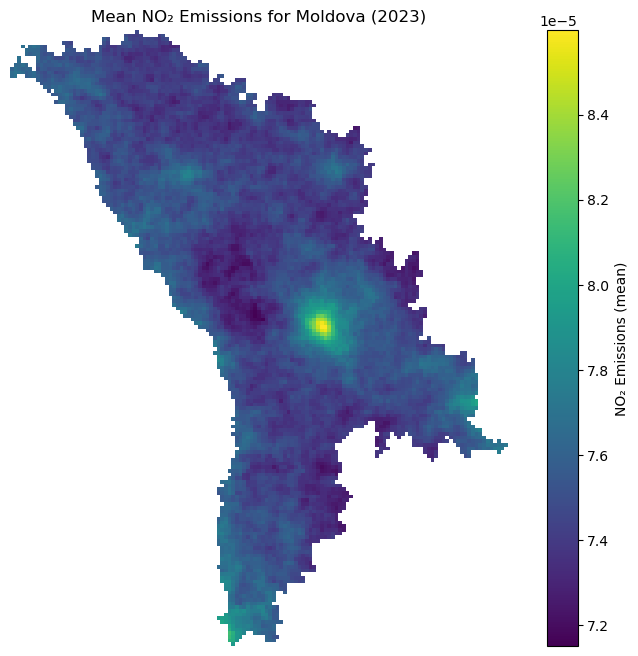

In [52]:
# plot the resulting image with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(np.ma.masked_where((image_array == -9999), image_array), cmap='viridis', interpolation='nearest')
plt.colorbar(label='NO₂ Emissions (mean)')
plt.title('Mean NO₂ Emissions for Moldova (2023)')
plt.axis('off')
plt.show()

### Visualizing 12 months images and output a gif 

In [12]:
images = []
for month, image_path in enumerate(images_path, start=1):
    dataset = gdal.Open(image_path)
    no2_data = dataset.ReadAsArray()

    # Create a plot and add it to the list
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(no2_data, cmap='viridis', interpolation='nearest')
    ax.set_title(f'NO₂ Emissions - Month {month}')
    plt.colorbar(im, ax=ax, label='NO₂ Emissions')
    plt.axis('off')  # Turn off axis for cleaner visualization

    # Save current plot as an image in memory
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
    
    plt.close(fig)  # Close the figure to free memory

In [13]:
# gif image output, please find in the folder
imageio.mimsave('no2_emissions_monthly_Moldova.gif', images, fps=1, loop=0)